### Generate recording w/ uniform drift

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
from tqdm import tqdm
import shutil
import h5py as h5
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
from spikeinterface.generation import generate_drifting_recording
import probeinterface as pi
from probeinterface.plotting import plot_probe
from spikeinterface.sorters import run_sorter
import spikeinterface.widgets as sw
from spikeinterface.comparison import compare_sorter_to_ground_truth
from spikeinterface.qualitymetrics import compute_quality_metrics
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

base_folder = Path("/home/alex/Simulations_WSL/LCA-Spike-Sorting")

In [3]:
# hyper params data generation
seed = 1
snr_min = 3

# complementary data informations
params = {
    "num_units": 60,
    "duration": 300,  # 5min
    "sampling_frequency": 10000.0,
    "probe_name": "Neuronexus-32",  # Tetrode
    "margin_um": 15.0,  # 10
    "minimum_z": 15.0,  # 10
    "maximum_z": 35.0,  # 35
    "minimum_distance": 20.0,
    "max_iteration": 2000,
    "displacement_sampling_frequency": 5.0,
    "drift_start_um": [0, 20],
    "drift_stop_um": [0, -20],
    "drift_step_um": 0.5,
    "drift_mode": "zigzag",
    "t_start_drift": 60.0,
    "t_end_drift": 180,
    "period_s": 1000,
    "firing_rates": [6.0, 10.0],  # previous [2,10]
    "refractory_period_ms": 4.0,
    "noise_levels": [10.5, 17],  # [10,15]
    "spatial_decay": 25.0,
    "seed": seed,
    "template_params": {
        "ms_before": 1.5,
        "ms_after": 3,
        "mode": "ellipsoid",
        "unit_params": {
            "alpha": (100.0, 700.0),
            "spatial_decay": (10, 50),
            "positive_amplitude": (0.1, 0.3),
            "smooth_ms": (0.03, 0.09),
            "depolarization_ms": (0.08, 0.17),
            "repolarization_ms": (0.4, 0.9),
        },
    },
}

In [4]:
# ## Generate Recording
# snr_min = 0
# max_sim = 0.7
# while True:
print(f" ################ seed : {seed} ################")
(static_rec, drift_rec, sorting) = generate_drifting_recording(
    num_units=params["num_units"],
    duration=params["duration"],
    sampling_frequency=params["sampling_frequency"],
    probe_name=params["probe_name"],
    generate_unit_locations_kwargs=dict(
        margin_um=params["margin_um"],
        minimum_z=params["minimum_z"],
        maximum_z=params["maximum_z"],
        minimum_distance=params["minimum_distance"],
        max_iteration=params["max_iteration"],
        distance_strict=False,
    ),
    generate_displacement_vector_kwargs=dict(
        displacement_sampling_frequency=params["displacement_sampling_frequency"],
        drift_start_um=[0, 20],
        drift_stop_um=[0, -20],
        drift_step_um=0.5,
        motion_list=[
            dict(
                drift_mode="zigzag",
                non_rigid_gradient=None,
                t_start_drift=params["t_start_drift"],
                t_end_drift=params["t_end_drift"],
                period_s=params["period_s"],
            ),
        ],
    ),
    generate_templates_kwargs=dict(
        ms_before=params["template_params"]["ms_before"],
        ms_after=params["template_params"]["ms_after"],
        mode="ellipsoid",
        unit_params=dict(
            alpha=(200.0, 700.0),
            spatial_decay=(10, 50),
            positive_amplitude=(0.1, 0.3),
            smooth_ms=(0.03, 0.09),
            depolarization_ms=(0.08, 0.17),
            repolarization_ms=(0.4, 0.9),
        ),
    ),
    generate_sorting_kwargs=dict(
        firing_rates=(params["firing_rates"][0], params["firing_rates"][1]),
        refractory_period_ms=params["refractory_period_ms"],
    ),
    generate_noise_kwargs=dict(
        noise_levels=(params["noise_levels"][0], params["noise_levels"][1]),
        spatial_decay=params["spatial_decay"],
    ),
    seed=seed,
)

job_kwargs = dict(n_jobs=-1, progress_bar=True)  # , chunk_duration="1s"
# filter recording
rec_f = si.preprocessing.bandpass_filter(
    static_rec, freq_min=300, freq_max=4000, dtype="float32"
)
gt_analyzer = si.create_sorting_analyzer(sorting, rec_f, sparse=False)
gt_analyzer.compute(
    ["random_spikes", "waveforms", "templates", "noise_levels"],
    **job_kwargs,
    verbose=False,
)

snr = compute_quality_metrics(
    gt_analyzer, metric_names=["snr"], n_jobs=-1
).values.squeeze()
snr_mask_idx = np.where(snr >= snr_min)[0]
snr_m = snr[snr_mask_idx]
min_snr = np.min(snr)
print(f"nb units with snr > {snr_min} : {len(snr_mask_idx)}")

# compute similarity
gt_analyzer.compute(["template_similarity"], **job_kwargs)
temp_sim = gt_analyzer.get_extension("template_similarity").get_data()
temp_sim -= np.eye(temp_sim.shape[0])  # remove diagonal
# remove units with snr < snr_min from similarity matrix
temp_sim = temp_sim[snr_mask_idx][:, snr_mask_idx]
max_sim = np.max(np.abs(temp_sim))
print(f"snr : {snr_m.round(3)}")
print(f"max sim : {max_sim:.2f}")

gt_raster = np.hstack(
    [
        [[sorting.to_spike_vector()[i][0]], [sorting.to_spike_vector()[i][1]]]
        for i in range(len(sorting.to_spike_vector()))
    ],
    dtype=np.int32,
)

# seed += 1

 ################ seed : 1 ################


/home/alex/Simulations_WSL/_spikeinterface_3289/src/spikeinterface/core/generate.py:1323: RuntimeWarning: divide by zero encountered in divide
  y = y / (y[-1] - y[0]) * (end_amp - start_amp)
/home/alex/Simulations_WSL/_spikeinterface_3289/src/spikeinterface/core/generate.py:1324: RuntimeWarning: invalid value encountered in subtract
  y = y - y[0] + start_amp


compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

nb units with snr > 3 : 43
snr : [15.603  8.275  9.532  6.57   6.271  4.606  6.213 17.449 12.75  10.436
  6.415  3.46   8.108  6.489 19.509  3.225  6.858 14.862  3.57   9.962
  7.011  4.653 16.911 10.843  5.151  3.773  8.555  5.049  3.7   16.365
 13.56  15.612 20.822  8.341 12.426  3.204  6.663 12.198 14.421  6.406
 10.859 15.254  9.899]
max sim : 0.86


In [5]:
# %matplotlib widget
# fig, ax = plt.subplots(3,5,tight_layout=False)
# ax = ax.flatten()
# sw.plot_unit_waveforms(gt_analyzer, max_spikes_per_unit=50)

In [6]:
# # Get gt_raster from sorting object and compute metrics
# gt_analyzer.compute(
#     [
#         "spike_amplitudes",
#         "correlograms",
#         "template_similarity",
#         "templates",
#     ],
#     **job_kwargs
# )

# # plot displacement vectors
# disp = drift_rec.displacement_vectors
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(disp[0][:, 1], "k")
# plt.show()

# # plot template_similarity as image (imshow) with color bar and annotation .2f
# plt.figure(figsize=(20, 20), dpi=200)
# plt.imshow(temp_sim, aspect="auto")
# plt.colorbar()
# plt.title("Template similarity")
# plt.xlabel("Unit")
# plt.ylabel("Unit")
# for i in range(temp_sim.shape[0]):
#     for j in range(temp_sim.shape[1]):
#         plt.text(i, j, f"{temp_sim[i, j]:.1f}", ha="center", va="center")
# plt.show()

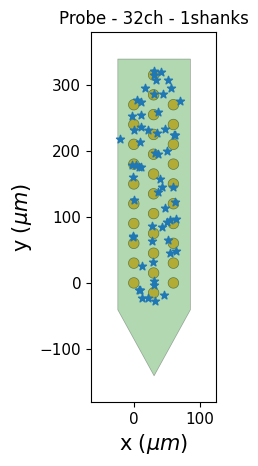

In [7]:
gt_analyzer.compute(["unit_locations"], **job_kwargs)
unit_locations = gt_analyzer.get_extension("unit_locations").get_data()
probe = gt_analyzer.get_probe()
fig, ax = plt.subplots()
plot_probe(probe, ax=ax)
ax.scatter(unit_locations[:, 0], unit_locations[:, 1], marker="*")
# incrize size of xticklabels and yticklabels
ax.tick_params(axis="both", which="major", labelsize=11)
plt.show()
# save fig as svg
fig.savefig("figures/Nx32_cell_locations.svg", format="svg")  # save as svg

### Detect Waveforms

In [8]:
fs = 10000  # int(static_rec.get_sampling_frequency())

# filter data
# rec_s = si.preprocessing.resample(static_rec, fs)
rec_f = si.preprocessing.bandpass_filter(
    static_rec, freq_min=300, freq_max=4000, dtype="float32"
)

In [9]:
gtr = gt_raster[:, np.isin(gt_raster[1, :], snr_mask_idx)]
# replace unit index by snr_mask_idx index
for i, idx in enumerate(snr_mask_idx):
    gtr[1, gtr[1, :] == idx] = i
# get unique units
units, counts = np.unique(gtr[1, :], return_counts=True)
print(f" units : {units} | counts : {counts}")

 units : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] | counts : [2447 1940 2938 2203 2298 2376 1847 2610 2491 2706 2170 2347 2106 2125
 3003 3020 2623 2174 1925 2405 1973 2624 2821 2542 2935 1840 2436 2415
 1824 2601 2926 2793 2442 2466 2727 2013 2744 2524 2711 1978 2018 2845
 2769]


In [10]:
# # save filtered and unfiltered recordings
# base_name = f"data/tetrode/tetrode{params['seed']}_n4"
# rec_f.save(format="binary", folder=base_name + "_recording", overwrite=True)

# # save gt_raster as h5
# with h5.File(base_name + "_gt_raster.h5", "w") as f:
#     f.create_dataset("gt_raster", data=gt_raster)
# f.close()

In [11]:
# Threshold detection
detection_th = 4
delta_time = 2  # 3ms
peaks = detect_peaks(
    rec_f,
    method="locally_exclusive",
    detect_threshold=detection_th,
    peak_sign="neg",
    # n_jobs=-1,
)
peaks_idx = peaks["sample_index"]
peaks_idx_copy = peaks_idx.copy()
print(f"number of detected peaks: {len(peaks_idx)}")

tp = np.zeros(len(snr_m))
fn = np.zeros_like(tp)
not_detected_gt_spikes = []
well_detected_spikes = []
for i in range(gtr.shape[1]):
    idx = np.where(
        np.abs(peaks_idx_copy - gtr[0, i]) <= delta_time * fs / 1000
    )  # search for a spike in a 1ms range
    if idx[0].size > 0:
        tp[gtr[1, i]] += 1
        well_detected_spikes.append(i)
        idx_closest = np.argmin(np.abs(peaks_idx_copy - gtr[0, i]))
        peaks_idx_copy = np.delete(peaks_idx_copy, idx_closest)
    else:
        fn[gtr[1, i]] += 1
        not_detected_gt_spikes.append(i)
precision = tp / counts
recall = tp / (tp + fn)
print(f" SNR : {snr_m.round(2)}")
print(f" tps : {tp} | fns : {fn}")
print(f" mean precision : {np.mean(precision):.2f}")
print(f" mean recall : {np.mean(recall):.2f}")

/home/alex/Simulations_WSL/_spikeinterface_3289/src/spikeinterface/core/job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

number of detected peaks: 104029
 SNR : [15.6   8.27  9.53  6.57  6.27  4.61  6.21 17.45 12.75 10.44  6.41  3.46
  8.11  6.49 19.51  3.23  6.86 14.86  3.57  9.96  7.01  4.65 16.91 10.84
  5.15  3.77  8.55  5.05  3.7  16.37 13.56 15.61 20.82  8.34 12.43  3.2
  6.66 12.2  14.42  6.41 10.86 15.25  9.9 ]
 tps : [2335. 1867. 2794. 2115. 2193. 2217. 1686. 2493. 2378. 2582. 2095. 1757.
 2027. 2062. 2883. 1929. 2496. 2089. 1397. 2300. 1887. 2465. 2696. 2438.
 2761. 1502. 2330. 2247. 1304. 2575. 2817. 2668. 2332. 2339. 2602. 1300.
 2603. 2396. 2594. 1907. 1908. 2721. 2647.] | fns : [ 112.   73.  144.   88.  105.  159.  161.  117.  113.  124.   75.  590.
   79.   63.  120. 1091.  127.   85.  528.  105.   86.  159.  125.  104.
  174.  338.  106.  168.  520.   26.  109.  125.  110.  127.  125.  713.
  141.  128.  117.   71.  110.  124.  122.]
 mean precision : 0.92
 mean recall : 0.92


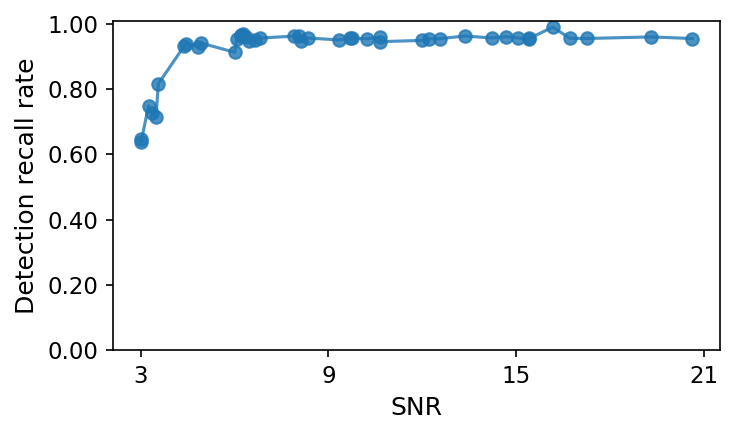

In [12]:
# plot recall and precision as bar plot with x-axis as sorted snr
# %matplotlib widget
perm_snr = np.argsort(snr[snr_mask_idx])
fig, ax = plt.subplots(figsize=(5, 3), dpi=150, tight_layout=True)
# ax.bar(snr_m[perm_snr], precision[perm_snr], label="precision")
# reduce bar width
ax.plot(snr_m[perm_snr], recall[perm_snr], label="recall", marker="o", alpha=0.8)
ax.set_xlabel("SNR", fontsize=12)
ax.set_ylabel("Detection recall rate", fontsize=12)
ax.set_xticks(np.arange(np.min(snr_m), np.max(snr_m) + 1, 6))
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([f"{i:.2f}" for i in np.arange(0, 1.1, 0.2)], fontsize=11)
ax.set_xticklabels(
    np.arange(np.min(snr_m), np.max(snr_m) + 1, 6, dtype=int), fontsize=11
)
# ax.legend()
plt.show()
fig.savefig("figures/Nx32_detection_recall.svg", format="svg")

In [13]:
# extract wvs around detected peaks
npeaks = peaks_idx.shape[0]
win_width = int(3 * fs / 1000)  # 3ms
nchan = rec_f.get_num_channels()
wvs = np.zeros((npeaks, nchan * win_width))
peaks_to_remove = []
for i in tqdm(range(npeaks), desc="extracting waveforms"):
    if (peaks_idx[i] - int(win_width * 0.40)) > 0 and (
        peaks_idx[i] + int(win_width * 0.60)
    ) < rec_f.get_num_frames():
        wv = rec_f.get_traces(
            start_frame=peaks_idx[i] - int(win_width * 0.40),
            end_frame=peaks_idx[i] + int(win_width * 0.60),
        ).T.ravel()
        wvs[i] = wv
    else:
        peaks_to_remove.append(i)

# remove peaks that are not extracted
wvs = np.delete(wvs, peaks_to_remove, axis=0)
peaks_idx = np.delete(peaks_idx, peaks_to_remove)
input_lca1_size = wvs.shape[1]

extracting waveforms: 100%|██████████| 104029/104029 [34:34<00:00, 50.15it/s] 


### Try&Run NSS / PCA+KMeans / WaveClus3

In [55]:
###Libraries parameters
## NSS
from model.Lca import LCA1iter, NSS_online
from utils.build_dataset import init_dataloader
from utils.metrics import GTSortingComparison

## PCA + KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Waveclus
import waveclus.pywaveclus.spike_detection as sd
import waveclus.pywaveclus.waveform_extraction as we
import waveclus.pywaveclus.feature_extraction as fe
import waveclus.pywaveclus.clustering as clu
import spikeinterface as si
from spikeinterface.preprocessing import filter

# init params
seed = 10
fs = 10000
ntrials = 1
nchan = 32
nneurons = 60
batch_size = 32
nPCs = 10

tmax = 180
mask0 = peaks_idx < tmax * fs
time_step = 15
t0, tend = 0, tmax
trange = (t0, tend)
time_step = np.arange(trange[0], trange[1] + 1, time_step) * fs

# normalize waveforms with l2-norm
l2_norm = np.linalg.norm(wvs, ord=2, axis=1)
if np.sum(l2_norm < 1e-6) > 0:
    print("Warning: some waveforms are null")
wvs_n = wvs / np.linalg.norm(wvs, ord=2, axis=1)[:, None]
dataloaders = init_dataloader(
    wvs_n[mask0], peaks_idx[mask0], batch_size, normalize=False
)


def run_nss(dataloader, seed, N=8, model="TDQ", ths=[0.05, 0.05], n_atoms=[500, 100]):
    params_nss = {
        "n_atoms1": n_atoms[0],
        "n_atoms2": n_atoms[1],
        "D1_positive": False,
        "D2_positive": True,
        "th1": ths[0],
        "th2": ths[1],
        "fs": fs,
        "tau": 2e-3,
        "iters": 200,
        "lr": 0.07,
        "n_model": model,
        "q": 2**N - 1,
        "seed": seed,
    }
    params_nss["gamma"] = 1 / params_nss["fs"] / params_nss["tau"]

    ## init lca1
    lca1 = LCA1iter(
        input_size=next(iter(dataloader))[0].shape[1],
        gamma=params_nss["gamma"],
        threshold=params_nss["th1"],
        n_atoms=params_nss["n_atoms1"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D1_positive"],
        seed=params_nss["seed"],
    )
    lca2 = LCA1iter(
        input_size=params_nss["n_atoms1"],
        gamma=params_nss["gamma"],
        threshold=params_nss["th2"],
        n_atoms=params_nss["n_atoms2"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D2_positive"],
        seed=params_nss["seed"],
    )
    nss = NSS_online(lca1, lca2, params_nss["iters"], scale_factor=1)

    # training NSS
    nss_out = []
    n_spikes = []
    for _, (bi, ri) in enumerate(tqdm(dataloader)):
        if int(ri[-1]) / fs > 240:  # reduce lr after 120s
            nss.lca1.lr, nss.lca2.lr = 0.01, 0.01
            nss.iters = 100
        nss(bi)
        nss_out.append(nss.lca2.decoded_out.numpy())
        n_spikes.append(nss.lca1.n_spikes + nss.lca2.n_spikes)
    nss_out = np.concatenate(nss_out, axis=0)
    n_spikes = np.concatenate(n_spikes, axis=0)
    labels = np.argmax(nss_out, axis=1).astype(int)

    return labels, n_spikes

In [ ]:
## Run NSS
N_values = [8]
nmodel = "TDQ"
for k, N in enumerate(N_values):
    print(f"Running NSS with N={N}")
    labels, nsp = run_nss(
        dataloaders, seed, N, model=nmodel, ths=[0.05, 0.05], n_atoms=[500, 100]
    )
    print(f"median nsp = {np.mean(nsp):.1f} +/- {np.std(nsp):.1f}")
    # compute evolution of f-score over time
    fscore_nss = np.zeros((nneurons, time_step.size - 1))
    for i in range(1, time_step.size):
        mask = (peaks_idx[mask0] >= time_step[i - 1]) & (
            peaks_idx[mask0] < time_step[i]
        )
        if np.sum(mask) == 0:
            continue
        else:
            gtri = gt_raster[
                :, (gt_raster[0] >= time_step[i - 1]) & (gt_raster[0] < time_step[i])
            ]
            gtsort_comp = GTSortingComparison(
                labels[mask], peaks_idx[mask0][mask], gtri, fs, delta_time=2
            )
            fscore_nss[:, i - 1] = gtsort_comp.get_fscore()
    print(f"mean F1s : {np.mean(fscore_nss[:,time_step[1:]>100*fs])*100:.1f} %")
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(time_step[1:] / fs, fscore_nss.T)
    plt.show()

mean F1s : 6.8 %


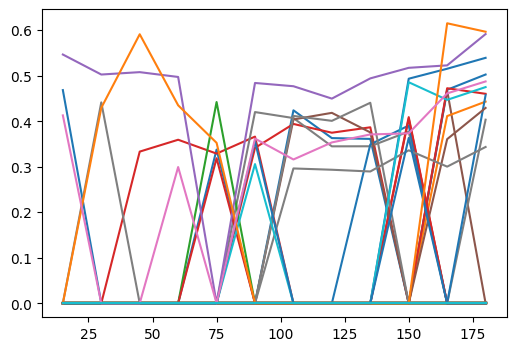

In [56]:
fscore_nss = np.zeros((nneurons, time_step.size - 1))
for i in range(1, time_step.size):
    mask = (peaks_idx[mask0] >= time_step[i - 1]) & (peaks_idx[mask0] < time_step[i])
    if np.sum(mask) == 0:
        continue
    else:
        gtri = gt_raster[
            :, (gt_raster[0] >= time_step[i - 1]) & (gt_raster[0] < time_step[i])
        ]
        gtsort_comp = GTSortingComparison(
            labels[mask], peaks_idx[mask0][mask], gtri, fs, delta_time=2
        )
        fscore_nss[:, i - 1] = gtsort_comp.get_fscore()
print(f"mean F1s : {np.mean(fscore_nss[:,time_step[1:]>100*fs])*100:.1f} %")
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(time_step[1:] / fs, fscore_nss.T)
plt.show()

In [ ]:
## PCA + KMeans
for t in range(ntrials):
    seed += t
    pcs = np.zeros((wvs_n.shape[0], nchan, nPCs))
    mask_train = peaks_idx < 120 * fs
    wvs_train = wvs_n[mask_train]
    wvs_eval = wvs_n[~mask_train]
    wvs_train = wvs_train.reshape(wvs_train.shape[0], nchan, -1)
    wvs_eval = wvs_eval.reshape(wvs_eval.shape[0], nchan, -1)
    for chi in range(nchan):
        pca = PCA(n_components=nPCs, random_state=seed, svd_solver="arpack")
        pcs[mask_train, chi] = pca.fit_transform(wvs_train[:, chi, :])
        pcs[~mask_train, chi] = pca.transform(wvs_eval[:, chi, :])

    pcs = pcs.reshape(-1, nchan * nPCs)
    kmeans = KMeans(n_clusters=4, init="random", random_state=seed, n_init=1).fit(pcs)
    labels = kmeans.labels_

    fscore_pk = np.zeros((nneurons, time_step.size - 1))
    for i in range(1, time_step.size):
        mask = (peaks_idx >= time_step[i - 1]) & (peaks_idx < time_step[i])
        if np.sum(mask) == 0:
            continue
        else:
            gtri = gt_raster[
                :, (gt_raster[0] >= time_step[i - 1]) & (gt_raster[0] < time_step[i])
            ]
            gtsort_comp = GTSortingComparison(
                labels[mask], peaks_idx[mask], gtri, fs, delta_time=1
            )
            fscore_pk[:, i - 1] = gtsort_comp.get_fscore()
    print(f"mean F1s : {np.mean(fscore_pk[:,time_step[1:]>100*fs])*100:.3f} %")
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(time_step[1:] / fs, fscore_pk.T)
plt.show()

In [ ]:
## Waveclus

# filter data
rec_bp2 = filter(static_rec, band=[300, 3000], btype="bandpass", filter_order=2)
rec_bp4 = filter(static_rec, band=[300, 3000], btype="bandpass", filter_order=4)

# Step 1: Spike Detection
spike_detection_results = sd.detect_spikes(static_rec, rec_bp2, rec_bp4)
# Step 2: Feature Extraction
wc_wvs = we.extract_waveforms(spike_detection_results, rec_bp2)
for t in range(ntrials):
    seed += 1
    features = fe.feature_extraction(wc_wvs, seed=seed)
    # Step 3: Clustering
    labels, metadata = clu.SPC_clustering(
        features, mintemp=0, maxtemp=1, swcycles=1, seed=seed
    )
    raster_wc = {}
    fscore_wc = np.zeros((nchan, nneurons, time_step.size - 1))
    for ci in range(nchan):
        peaks = spike_detection_results[ci]["indexes"]
        label = labels[ci]
        gtr = gt_raster

        for i in range(1, time_step.size):
            mask = (peaks >= time_step[i - 1]) & (peaks < time_step[i])
            if np.sum(mask) == 0:
                continue
            else:
                labeli = label[mask]
                peaksi = peaks[mask]
                gtri = gtr[:, (gtr[0] >= time_step[i - 1]) & (gtr[0] < time_step[i])]
                gtsort_comp_nss = GTSortingComparison(
                    labeli, peaksi, gtri, fs, delta_time=2
                )
                # fscore = gtsort_comp_nss.get_fscore()
                # if np.mean(fscore) > 0:

                fscore_wc[ci, :, i - 1] = gtsort_comp_nss.get_fscore()
                # print(f"F1s WC: {fscore_wc[ci, :, i - 1]*100}%")
        # print(f"F1s WC: {fscore_wc[ci]*100}%")
    # for each neuron determine the best channel
    best_chan = np.argmax(np.sum(fscore_wc, axis=2), axis=0)
    fscore_wc_best = np.zeros((nneurons, time_step.size - 1))
    # fill fscore_wc_best with the best channel from fscore_wc
    for ni in range(nneurons):
        fscore_wc_best[ni] = fscore_wc[best_chan[ni], ni]
    print(f"F1s WC: {fscore_wc_best.mean()*100:.2f}%")

### Save if good enough

In [14]:
# save static_rec, drift_rec and sorting to h5py file
base_name = f"./data/Nx32/Nx32{params['seed']}_n43_static"
with h5.File(base_name + ".h5", "w") as f:
    f.create_dataset("wvs", data=wvs)
    # f.create_dataset("wvs_gt", data=wvs_gt)
    f.create_dataset("peaks_idx", data=peaks_idx)
    f.create_dataset("gt_raster", data=gtr)
    f.create_dataset("snr", data=snr)
    # f.create_dataset("templates", data=templates)
    f.create_group("params")
    # store params as a list of string
    for key, value in params.items():
        f["params"].create_dataset(key, data=str(value))
f.close()

In [15]:
# save rec_f and sorting
base_name = f"./data/Nx32/Nx32{params['seed']}_n43"
static_rec.save(folder=base_name + "_recording", overwrite=True)
sorting.save(folder=base_name + "_sorting", overwrite=True)

write_binary_recording 
n_jobs=1 - samples_per_chunk=10,000 - chunk_memory=1.22 MiB - total_memory=1.22 MiB - chunk_duration=1.00s


/home/alex/Simulations_WSL/_spikeinterface_3289/src/spikeinterface/core/job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

NumpyFolder: 60 units - 1 segments - 10.0kHz

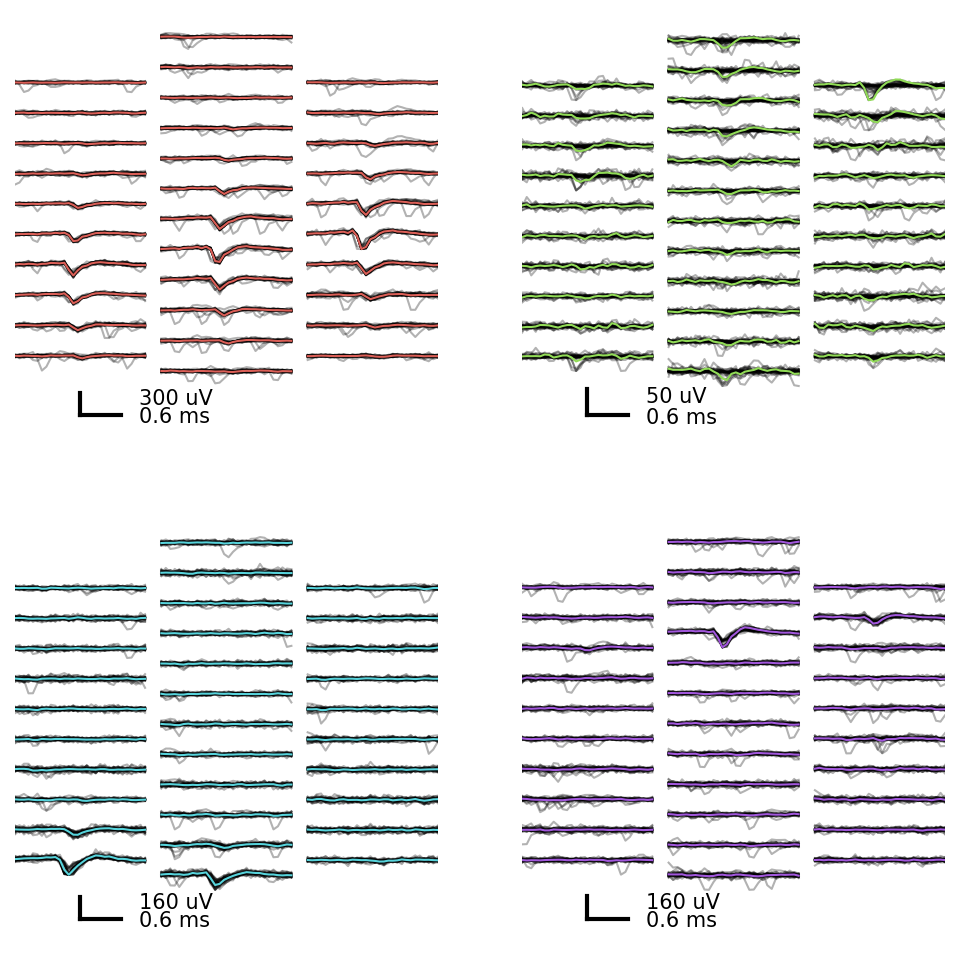

In [51]:
# for each neuron get idx in gt_raster compute the closest one in peaks_idx, get 50 wvs and plot them
# to see if they are well detected
import MEAutility as mu

mea = mu.return_mea("Neuronexus-32")
# mu.plot_mea_recording(wvs[0].reshape(32,-1), mea, spacing=9)
nneurons = params["num_units"]
neuron_to_plot = 4
# get a cmap with 4 color from sns
import seaborn as sns

cmap = sns.color_palette("hls", neuron_to_plot)
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=150)
axs = axs.flatten()
nwvs_per_neuron = 30
nchan = rec_f.get_num_channels()
for ni in range(neuron_to_plot):
    idx_ni = np.where(gt_raster[1] == ni)[0]
    wvs_ni = []
    j = 0
    for gti in idx_ni:
        idx = np.argmin(np.abs(peaks_idx - gt_raster[0, gti]))
        mu.plot_mea_recording(
            wvs[idx].reshape(nchan, -1), mea, spacing=9, alpha=0.3, ax=axs[ni]
        )
        wvs_ni.append(wvs[idx])
        j += 1
        if j == nwvs_per_neuron:
            break
    # plot mean wvs in red
    mu.plot_mea_recording(
        np.mean(wvs_ni, axis=0).reshape(nchan, -1),
        mea=mea,
        spacing=9,
        colors=cmap[ni],
        lw=1,
        ax=axs[ni],
        scalebar=True,
        time=3,
    )
plt.show()
# save figure
fig.savefig("figures/Nx32_4templates.svg", format="svg", bbox_inches="tight", dpi=150)

### Run simple sorter

In [ ]:
sorter_folder = base_folder / "drift_simple_sorter"
if sorter_folder.exists():
    shutil.rmtree(sorter_folder)

sorter_params = dict(
    apply_preprocessing=True,
    # apply_preprocessing=False,
    waveforms=dict(ms_before=1.0, ms_after=1.8),
    filtering=dict(freq_min=300, freq_max=6000.0),
    detection=dict(
        peak_sign="neg", detect_threshold=4.0, exclude_sweep_ms=0.4, radius_um=100
    ),
    features=dict(n_components=3),
    clustering=dict(method="hdbscan"),
    # clustering=dict(method="kmeans", n_clusters=3),
    # clustering=dict(method="gaussian_mixture", n_components=5),
    # clustering=dict(method="mean_shift", bin_seeding=True),
    # clustering=dict(method="affinity_propagation"),
    job_kwargs=dict(n_jobs=-1),
)
sorting_simple = run_sorter(
    "simple", static_rec, output_folder=sorter_folder, verbose=True, **sorter_params
)
print(sorting_simple)

In [ ]:
# compute sorting accuracy
cmp_gt = compare_sorter_to_ground_truth(
    sorting,
    sorting_simple,
    n_jobs=-1,
    match_mode="best",
    delta_time=3,
)
perf = cmp_gt.get_performance()
acc_mean = perf["accuracy"].mean()
print(f"Accuracy: {acc_mean}")

### Run Spyking-Circus 2

In [ ]:
sorter_name = "spykingcircus2"

sorter_folder = base_folder / f"drift_{sorter_name}"
if sorter_folder.exists():
    shutil.rmtree(sorter_folder)


sorting2 = run_sorter(
    sorter_name, static_rec, output_folder=sorter_folder, verbose=True
)

In [ ]:
cmp_acc = compare_sorter_to_ground_truth(
    sorting, sorting2, n_jobs=-1, match_mode="best"
)
perf = cmp_acc.get_performance()
acc = perf["accuracy"].values
print(f" mean acc over {snr_min} : {np.mean(acc[snr_mask_idx]):.2f}")

cmp_fscore = compare_sorter_to_ground_truth(
    sorting,
    sorting2,
    delta_time=2,
    n_jobs=-1,
    match_mode="hungarian",
    sampling_frequency=fs,
)
## compute F-score
matching_unit = cmp_fscore.best_match_12.to_numpy().astype(int)
conf_matrix = cmp_fscore.get_confusion_matrix()
fscore = np.zeros(params["num_units"])
for i in range(params["num_units"]):
    if matching_unit[i] == -1:
        print("No matching unit found for neuron ", i)
        continue
    tp = conf_matrix[matching_unit[i]][i]
    fp = conf_matrix[matching_unit[i]].to_numpy()[-1]
    fn = conf_matrix["FN"].to_numpy()[0]
    fscore[i] = 2 * tp / (2 * tp + fp + fn)

print(f" mean fscore over {snr_min} : {np.mean(fscore[snr_mask_idx]):.2f}")

In [ ]:
%matplotlib widget
sw.plot_traces(static_rec, backend='ipywidgets', order_channel_by_depth=True)